# 22.02.21 과제, violin plot

##### 참고
https://github.com/nowhyun/Study/blob/master/%EB%B0%95%EC%8A%A4_%ED%94%8C%EB%A1%AF(Box_Plot)%2C_%EB%B0%94%EC%9D%B4%EC%98%AC%EB%A6%BF_%ED%94%8C%EB%A1%AF(Violin_Plot).ipynb

violin그래프 그릴 때는 mean을 쓰지 않는다.

# top

RF top10
[51277, 50912, 51006, 63323026201, 50862, 50983, 51003, 51275, 904224461, 50882]

M1 entropy top10
[409176230, 51003, 487980125, 50862, 50813, 50868, 409606211, 338004902, 45006701, 55390007310]

# Library

In [1]:
#데이터 분석 라이브러리
import numpy as np
print("numpy version: {}". format(np.__version__))

import pandas as pd

#시각화 라이브러리
import matplotlib as mpl
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(mpl.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))

#딥러닝 라이브러리
import tensorflow as tf

#기타 라이브러리
import os
import random
import time

#경고 에러 무시
import warnings
warnings.filterwarnings('ignore')
print('-'*50)

#시간 확인을 용이하게 해주는 라이브러리
from tqdm import tqdm

#결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

numpy version: 1.19.5
matplotlib version: 3.4.2
seaborn version: 0.11.1
--------------------------------------------------


# GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


# CPU

In [3]:
#GPU 사용 설정, -1이면 CPU 사용
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# data load

In [4]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
    from keras.models import load_model
    lstm2 = load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')
    
# 3) baseline
    # FEATURES
    a = pd.read_csv('/project/LSH/total_data_7727.csv')
    features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 

    results = []    
    preds = lstm2.predict(X_test)
    preds_mean = np.mean(preds) # base preds

    results.append({'feature':'BASELINE','baseline':preds_mean})
#     tf.device('/device:GPU:0').close()

Using TensorFlow backend.


In [6]:
preds.shape

(1545, 1)

In [12]:
preds

array([[0.8576751 ],
       [0.8816626 ],
       [0.81608653],
       ...,
       [0.8417419 ],
       [0.9241805 ],
       [0.829637  ]], dtype=float32)

In [14]:
# pd.Series(preds.flatten(), name = 'preds').to_csv('preds_base.csv', index = False)

In [15]:
pd.read_csv('preds_base.csv')

preds
0     0.857675
1     0.881663
2     0.816087
3     0.948484
4     0.950073
...        ...
1540  0.702804
1541  0.113465
1542  0.841742
1543  0.924180
1544  0.829637

[1545 rows x 1 columns]

In [7]:
results

[{'feature': 'BASELINE', 'baseline': 0.6369324}]

In [ ]:
# results 저장
results = [{'feature': 'BASELINE', 'baseline': 0.6369324}]

# all to 1

In [4]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
with tf.device('/device:GPU:0'): #모델 돌리는 동안 다 이 안에 넣어놓기
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
    from keras.models import load_model
    lstm2 = load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# 3) all_to_1
    # FEATURES
    a = pd.read_csv('/project/LSH/total_data_7727.csv')
    features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 


    preds2_dic = {} # 그래프 만들 때 쓸 dic
    preds2_mean_lst = [] # 이거는 df 만들 때만 사용.

    for k in tqdm(range(len(features))):

        # REVERSE ALL FEATURE K
        save_col = X_test[:,:,k].copy()

        # all_to_1
        X_test[:,:,k] = 1

        # all_to_0
    #     X_test[:,:,k] = 0

        # inverse
    #     X_test[:,:,k] = np.where(X_test[:,:,k]==1, 2, X_test[:,:,k])
    #     X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
    #     X_test[:,:,k] = np.where(X_test[:,:,k]==2, 0, X_test[:,:,k])

        # COMPUTE BCE WITH FEATURE K all_to_1, preds2_mean_list
        preds2 = lstm2.predict(X_test)
        preds2_dic[features[k]] = preds2 # 그래프 만들 때 쓸 dic
        preds2_mean_lst.append(np.mean(preds2)) # 이거는 df 만들 때만 사용.

#         loss_bce = bce(y_test, preds2).numpy()
#         results.append({'feature':features[k],'mean_preds2':np.mean(preds2)})
        X_test[:,:,k] = save_col

Using TensorFlow backend.
100%|██████████| 4068/4068 [30:14<00:00,  2.24it/s]


## Data processing

In [5]:
df1 = pd.DataFrame(preds2_mean_lst)

######################################################################
df_all_to_1 = df1.copy()
all_to_1_all_preds2 = preds2_dic.copy()

In [6]:
df_all_to_1.columns = ['mean_preds2']
# df_all_to_1

In [7]:
# df_all_to_1.to_csv('all_to_1_mean_preds2.csv', index = False)

In [11]:
pd.read_csv('all_to_1_mean_preds2.csv')

mean_preds2
0        0.617006
1        0.610829
2        0.669560
3        0.603050
4        0.685346
...           ...
4063     0.587123
4064     0.634779
4065     0.725083
4066     0.644183
4067     0.653701

[4068 rows x 1 columns]

## Violin plot으로 만들기 위한 전처리

In [8]:
for i,j in enumerate(all_to_1_all_preds2.keys()):
    if i == 0:
        ori = pd.Series(all_to_1_all_preds2[j].flatten(), name = j)
    
    else:
        tmp = pd.Series(all_to_1_all_preds2[j].flatten(), name = j)
        ori = pd.concat([ori, tmp], axis = 1)   # ori 계속 덮어쓰기

In [9]:
# ori.to_csv('all_to_1_all_preds2.csv', index=False)

## Violin plot

### data load

In [12]:
data_all_to_1 = pd.read_csv('all_to_1_all_preds2.csv')

0     50803     50804     50805     50806     50808     50809  \
0     0.846375  0.828797  0.886364  0.818052  0.894676  0.868479  0.883605   
1     0.881663  0.860867  0.900111  0.855075  0.906826  0.887680  0.898340   
2     0.809148  0.789608  0.855021  0.774744  0.863110  0.832881  0.850730   
3     0.948484  0.947762  0.949039  0.947338  0.949946  0.949026  0.949573   
4     0.950014  0.949542  0.950909  0.949296  0.951106  0.950419  0.950814   
...        ...       ...       ...       ...       ...       ...       ...   
1540  0.698868  0.656243  0.778094  0.629322  0.793677  0.736258  0.769759   
1541  0.113465  0.110384  0.115172  0.110502  0.118206  0.113262  0.115121   
1542  0.747045  0.807824  0.875055  0.796489  0.884868  0.858360  0.873004   
1543  0.924180  0.917329  0.932129  0.914148  0.934119  0.927384  0.931208   
1544  0.755009  0.793479  0.857136  0.782471  0.880964  0.842863  0.864369   

         50811     50813     50814  ...  74300000533  74312000660  \
0     0.889142  0.911049  0.812572  ...     0.897870     0.872531   
1     0.902445  0.918431  0.851341  ...     0.909656     0.891983   
2     0.856516  0.886325  0.769114  ...     0.867722     0.834583   
3     0.949747  0.950726  0.947166  ...     0.950035     0.949028   
4     0.950956  0.950759  0.949190  ...     0.951166     0.950445   
...        ...       ...       ...  ...          ...          ...   
1540  0.782063  0.836001  0.621491  ...     0.803270     0.738057   
1541  0.116262  0.121820  0.110261  ...     0.120161     0.115104   
1542  0.878650  0.904111  0.790904  ...     0.888927     0.859530   
1543  0.932676  0.937470  0.912925  ...     0.935196     0.928202   
1544  0.872620  0.905289  0.777320  ...     0.885681     0.849088   

      74312001370  76329301205  76336045517  78112001103  79511050204  \
0        0.890084     0.857579     0.854523     0.791205     0.855482   
1        0.904220     0.881559     0.879545     0.839084     0.880150   
2        0.857071     0.815674     0.812697     0.748243     0.813302   
3        0.949689     0.948452     0.948374     0.946563     0.948421   
4        0.950933     0.950065     0.949992     0.948771     0.950025   
...           ...          ...          ...          ...          ...   
1540     0.781534     0.701614     0.697465     0.588300     0.698932   
1541     0.118156     0.113426     0.113208     0.109666     0.113280   
1542     0.880022     0.841800     0.838082     0.768621     0.839080   
1543     0.933013     0.924103     0.923438     0.907445     0.923687   
1544     0.874052     0.829149     0.825840     0.756075     0.827025   

      87701071218  87701083336  87701089415  
0        0.913433     0.864324     0.872339  
1        0.921045     0.886565     0.891553  
2        0.889423     0.824123     0.834026  
3        0.950756     0.948679     0.949029  
4        0.951663     0.950215     0.950448  
...           ...          ...          ...  
1540     0.849694     0.716544     0.737101  
1541     0.127159     0.114476     0.114997  
1542     0.907172     0.849928     0.858971  
1543     0.939651     0.925951     0.928164  
1544     0.909160     0.837981     0.849157  

[1545 rows x 4068 columns]

# all to 0

In [4]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
    from keras.models import load_model
    lstm2 = load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')
    
# 3) all_to_0
    # FEATURES
    a = pd.read_csv('/project/LSH/total_data_7727.csv')
    features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 


    preds2_dic = {} # 그래프 만들 때 쓸 dic
    preds2_mean_lst = [] # 이거는 df 만들 때만 사용.

    for k in tqdm(range(len(features))):

        # REVERSE ALL FEATURE K
        save_col = X_test[:,:,k].copy()

        # all_to_1
    #     X_test[:,:,k] = 1

        # all_to_0
        X_test[:,:,k] = 0

        # inverse
    #     X_test[:,:,k] = np.where(X_test[:,:,k]==1, 2, X_test[:,:,k])
    #     X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
    #     X_test[:,:,k] = np.where(X_test[:,:,k]==2, 0, X_test[:,:,k])

        # COMPUTE BCE WITH FEATURE K all_to_1, preds2_mean_list
        preds2 = lstm2.predict(X_test)
        preds2_dic[features[k]] = preds2 # 그래프 만들 때 쓸 dic
        preds2_mean_lst.append(np.mean(preds2)) # 이거는 df 만들 때만 사용.

#         loss_bce = bce(y_test, preds2).numpy()
#         results.append({'feature':features[k],'bce':loss_bce})
        X_test[:,:,k] = save_col

Using TensorFlow backend.
100%|██████████| 4068/4068 [30:23<00:00,  2.23it/s]


## Data processing

In [5]:
df1 = pd.DataFrame(preds2_mean_lst)

######################################################################
df_all_to_0 = df1.copy()
all_to_0_all_preds2 = preds2_dic.copy()

# base_value = df1.iloc[0,1]
# df_all_best['baseline_bce'] = base_value
# # df_all_best
# df_all_best['diff'] = df_all_best['bce']-df_all_best['baseline_bce']

# df_all_best = df_all_best.drop(index=[0])
# df_all_best = df_all_best.sort_values(by=['diff'])

# #######################################################################

# diffdf = df_all_best[['feature','diff']]
# diffdf = diffdf.sort_values(by='diff')

In [6]:
df_all_to_0
all_to_0_all_preds2

0
0     0.677977
1     0.636985
2     0.634996
3     0.636940
4     0.636746
...        ...
4063  0.637362
4064  0.636932
4065  0.636043
4066  0.636931
4067  0.636931

[4068 rows x 1 columns]

{0: array([[0.8934177 ],
        [0.910596  ],
        [0.86493754],
        ...,
        [0.8417419 ],
        [0.9354465 ],
        [0.84076506]], dtype=float32),
 50803: array([[0.8576751 ],
        [0.8816626 ],
        [0.81608653],
        ...,
        [0.8417419 ],
        [0.9241805 ],
        [0.829637  ]], dtype=float32),
 50804: array([[0.8576751 ],
        [0.8816626 ],
        [0.81608653],
        ...,
        [0.8417419 ],
        [0.9241805 ],
        [0.8123625 ]], dtype=float32),
 50805: array([[0.8576751 ],
        [0.8816626 ],
        [0.81608653],
        ...,
        [0.8417419 ],
        [0.9241805 ],
        [0.829637  ]], dtype=float32),
 50806: array([[0.8576751 ],
        [0.8816626 ],
        [0.81608653],
        ...,
        [0.8417419 ],
        [0.9241805 ],
        [0.829637  ]], dtype=float32),
 50808: array([[0.8576751 ],
        [0.8816626 ],
        [0.81608653],
        ...,
        [0.84656435],
        [0.9241805 ],
        [0.829637  ]], dtype=

In [9]:
df_all_to_0.columns = ['mean_preds2']
# df_all_to_0

In [14]:
# df_all_to_0.to_csv('all_to_0_mean_preds2.csv', index = False)

In [15]:
# 확인 cell
pd.read_csv('all_to_0_mean_preds2.csv')

mean_preds2
0        0.677977
1        0.636985
2        0.634996
3        0.636940
4        0.636746
...           ...
4063     0.637362
4064     0.636932
4065     0.636043
4066     0.636931
4067     0.636931

[4068 rows x 1 columns]

## Violin plot으로 만들기 위한 전처리

In [34]:
# pd.DataFrame(all_to_0_all_preds2)
for i,j in enumerate(all_to_0_all_preds2.keys()):
#     len(all_to_0_all_preds2[j])
#     all_to_0_all_preds2[j].flatten()
    if i == 0:
        ori = pd.Series(all_to_0_all_preds2[j].flatten(), name = j)
    
    else:
        tmp = pd.Series(all_to_0_all_preds2[j].flatten(), name = j)
        ori = pd.concat([ori, tmp], axis = 1)   # ori 계속 덮어쓰기
#     break

In [ ]:
# all_to_0_all_preds2.keys()

In [36]:
# ori.to_csv('all_to_0_all_preds2.csv', index=False)

## violin plot 그리기

### data load

In [39]:
data = pd.read_csv('all_to_0_all_preds2.csv')

In [61]:
data
data['50803']

0     50803     50804     50805     50806     50808     50809  \
0     0.893418  0.857675  0.857675  0.857675  0.857675  0.857675  0.857675   
1     0.910596  0.881663  0.881663  0.881663  0.881663  0.881663  0.881663   
2     0.864938  0.816087  0.816087  0.816087  0.816087  0.816087  0.816087   
3     0.950064  0.948484  0.947645  0.948484  0.948484  0.948484  0.948484   
4     0.951145  0.950073  0.950073  0.950073  0.950073  0.950073  0.950073   
...        ...       ...       ...       ...       ...       ...       ...   
1540  0.802730  0.702804  0.702217  0.702804  0.702804  0.702804  0.702804   
1541  0.121324  0.113465  0.113465  0.113465  0.113465  0.113609  0.113465   
1542  0.841742  0.841742  0.841742  0.841742  0.841742  0.846564  0.843166   
1543  0.935446  0.924180  0.924180  0.924180  0.924180  0.924180  0.924180   
1544  0.840765  0.829637  0.812362  0.829637  0.829637  0.829637  0.829637   

         50811     50813     50814  ...  74300000533  74312000660  \
0     0.857675  0.857675  0.857675  ...     0.857675     0.857675   
1     0.881663  0.881663  0.881663  ...     0.881663     0.881663   
2     0.816087  0.816087  0.816087  ...     0.816087     0.816087   
3     0.948484  0.948484  0.948484  ...     0.948484     0.948484   
4     0.950073  0.948576  0.950073  ...     0.950073     0.950073   
...        ...       ...       ...  ...          ...          ...   
1540  0.702804  0.692118  0.702804  ...     0.702804     0.702804   
1541  0.113465  0.113465  0.113465  ...     0.113465     0.113465   
1542  0.842124  0.841742  0.841742  ...     0.841742     0.841742   
1543  0.924180  0.920908  0.924180  ...     0.924180     0.924180   
1544  0.829637  0.829637  0.829637  ...     0.829637     0.829637   

      74312001370  76329301205  76336045517  78112001103  79511050204  \
0        0.857675     0.857675     0.857675     0.857675     0.857675   
1        0.881663     0.881663     0.881663     0.881663     0.881663   
2        0.816087     0.816087     0.816087     0.816087     0.816087   
3        0.948484     0.948484     0.948484     0.948484     0.948484   
4        0.950073     0.950073     0.950073     0.950073     0.950073   
...           ...          ...          ...          ...          ...   
1540     0.702804     0.702804     0.702804     0.702804     0.702804   
1541     0.113465     0.113465     0.113465     0.113465     0.113465   
1542     0.841742     0.841742     0.841742     0.841742     0.841742   
1543     0.924180     0.924180     0.924180     0.924180     0.924180   
1544     0.829637     0.829637     0.829637     0.829637     0.829637   

      87701071218  87701083336  87701089415  
0        0.857675     0.857675     0.857675  
1        0.881663     0.881663     0.881663  
2        0.816087     0.816087     0.816087  
3        0.948484     0.948484     0.948484  
4        0.950073     0.950073     0.950073  
...           ...          ...          ...  
1540     0.702804     0.702804     0.702804  
1541     0.113465     0.113465     0.113465  
1542     0.841742     0.841742     0.841742  
1543     0.924180     0.924180     0.924180  
1544     0.829637     0.829637     0.829637  

[1545 rows x 4068 columns]

0       0.857675
1       0.881663
2       0.816087
3       0.948484
4       0.950073
          ...   
1540    0.702804
1541    0.113465
1542    0.841742
1543    0.924180
1544    0.829637
Name: 50803, Length: 1545, dtype: float64

RF top10
[51277, 50912, 51006, 63323026201, 50862, 50983, 51003, 51275, 904224461, 50882]

M1 entropy top10
[409176230, 51003, 487980125, 50862, 50813, 50868, 409606211, 338004902, 45006701, 55390007310]

In [65]:
# 스타일 설정
sns.set_style('whitegrid')

# 사용할 특성 2가지 선택
hue_col = [0,1]
x_col = '51277' #문자로 들어있음.
y_col = '51277'

#데이터 확인
x_col_val = data[x_col].values
y_col_val = data[y_col].values
hue_col_val = [0,1]#data[hue_col].values
print('{}행의 값:\n{}'.format(x_col, x_col_val))
print('{}행의 값:\n{}'.format(y_col, y_col_val))
print('{}행의 값:\n{}'.format(hue_col, hue_col_val))

51277행의 값:
[0.8576751  0.7007793  0.6259553  ... 0.8417419  0.87259173 0.829637  ]
51277행의 값:
[0.8576751  0.7007793  0.6259553  ... 0.8417419  0.87259173 0.829637  ]
[0, 1]행의 값:
[0, 1]


# inverse

In [13]:
# 1) DATA 
import random    
# ---------------------
seed_num = 42
# ---------------------
random.seed(seed_num)

x = np.load('/project/LSH/x_(7727,10,4068).npy')
y = np.load('/project/LSH/y_(7727,1).npy')

idx = list(range(len(x)))
random.shuffle(idx)

i = round(x.shape[0]*0.8)
X_train, y_train = x[idx[:i],:,:], y[idx[:i]]
X_test, y_test = x[idx[i:],:,:], y[idx[i:]]

# 2) MODEL
with tf.device('/device:GPU:0'):
    tf.config.experimental.set_virtual_device_configuration(gpus[0], 
                                                            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5*1024)])
    from keras.models import load_model
    lstm2 = load_model('/project/LSH/model/(LSTM_best_4068)seed42-05-0.5029.hdf5')

# 3) inverse
    # FEATURES
    a = pd.read_csv('/project/LSH/total_data_7727.csv')
    features = list(a['ITEMID'].sort_values().unique()) # 4068개 ITEMID 


    preds2_dic = {} # 그래프 만들 때 쓸 dic
    preds2_mean_lst = [] # 이거는 df 만들 때만 사용.

    for k in tqdm(range(len(features))):

        # REVERSE ALL FEATURE K
        save_col = X_test[:,:,k].copy()

        # all_to_1
    #     X_test[:,:,k] = 1

        # all_to_0
    #     X_test[:,:,k] = 0

        # inverse
        X_test[:,:,k] = np.where(X_test[:,:,k]==1, 2, X_test[:,:,k])
        X_test[:,:,k] = np.where(X_test[:,:,k]==0, 1, X_test[:,:,k])
        X_test[:,:,k] = np.where(X_test[:,:,k]==2, 0, X_test[:,:,k])

        # COMPUTE BCE WITH FEATURE K all_to_1, preds2_mean_list
        preds2 = lstm2.predict(X_test)
        preds2_dic[features[k]] = preds2 # 그래프 만들 때 쓸 dic
        preds2_mean_lst.append(np.mean(preds2)) # 이거는 df 만들 때만 사용.

#         loss_bce = bce(y_test, preds2).numpy()
#         results.append({'feature':features[k],'bce':loss_bce})
        X_test[:,:,k] = save_col

100%|██████████| 4068/4068 [30:18<00:00,  2.24it/s]


## Data processing

In [14]:
df1 = pd.DataFrame(preds2_mean_lst)

######################################################################
df_inverse = df1.copy()
inverse_all_preds2 = preds2_dic.copy()

In [15]:
df_inverse.columns = ['mean_preds2']
# df_inverse

In [16]:
# df_inverse.to_csv('inverse_mean_preds2.csv', index = False)

In [20]:
pd.read_csv('inverse_mean_preds2.csv')

mean_preds2
0        0.658366
1        0.610879
2        0.667633
3        0.603060
4        0.685195
...           ...
4063     0.587544
4064     0.634779
4065     0.724196
4066     0.644181
4067     0.653699

[4068 rows x 1 columns]

## Violin plot으로 만들기 위한 전처리

In [17]:
for i,j in enumerate(inverse_all_preds2.keys()):
    if i == 0:
        ori = pd.Series(inverse_all_preds2[j].flatten(), name = j)
    
    else:
        tmp = pd.Series(inverse_all_preds2[j].flatten(), name = j)
        ori = pd.concat([ori, tmp], axis = 1)   # ori 계속 덮어쓰기

In [18]:
# ori.to_csv('inverse_all_preds2.csv', index=False)

## Violin plot

### data load

In [19]:
data_inverse = pd.read_csv('inverse_all_preds2.csv')

In [21]:
data_inverse

0     50803     50804     50805     50806     50808     50809  \
0     0.887100  0.828797  0.886364  0.818052  0.894676  0.868479  0.883605   
1     0.910596  0.860867  0.900111  0.855075  0.906826  0.887680  0.898340   
2     0.860527  0.789608  0.855021  0.774744  0.863110  0.832881  0.850730   
3     0.950064  0.947762  0.948257  0.947338  0.949946  0.949026  0.949573   
4     0.951099  0.949542  0.950909  0.949296  0.951106  0.950419  0.950814   
...        ...       ...       ...       ...       ...       ...       ...   
1540  0.799976  0.656243  0.776968  0.629322  0.793677  0.736258  0.769759   
1541  0.121324  0.110384  0.115172  0.110502  0.118206  0.113395  0.115121   
1542  0.747045  0.807824  0.875055  0.796489  0.884868  0.862500  0.874027   
1543  0.935446  0.917329  0.932129  0.914148  0.934119  0.927384  0.931208   
1544  0.773395  0.793479  0.842998  0.782471  0.880964  0.842863  0.864369   

         50811     50813     50814  ...  74300000533  74312000660  \
0     0.889142  0.911049  0.812572  ...     0.897870     0.872531   
1     0.902445  0.918431  0.851341  ...     0.909656     0.891983   
2     0.856516  0.886325  0.769114  ...     0.867722     0.834583   
3     0.949747  0.950726  0.947166  ...     0.950035     0.949028   
4     0.950956  0.949469  0.949190  ...     0.951166     0.950445   
...        ...       ...       ...  ...          ...          ...   
1540  0.782063  0.830687  0.621491  ...     0.803270     0.738057   
1541  0.116262  0.121820  0.110261  ...     0.120161     0.115104   
1542  0.878937  0.904111  0.790904  ...     0.888927     0.859530   
1543  0.932676  0.936004  0.912925  ...     0.935196     0.928202   
1544  0.872620  0.905289  0.777320  ...     0.885681     0.849088   

      74312001370  76329301205  76336045517  78112001103  79511050204  \
0        0.890084     0.857579     0.854523     0.791205     0.855482   
1        0.904220     0.881559     0.879545     0.839084     0.880150   
2        0.857071     0.815674     0.812697     0.748243     0.813302   
3        0.949689     0.948452     0.948374     0.946563     0.948421   
4        0.950933     0.950065     0.949992     0.948771     0.950025   
...           ...          ...          ...          ...          ...   
1540     0.781534     0.701614     0.697465     0.588300     0.698932   
1541     0.118156     0.113426     0.113208     0.109666     0.113280   
1542     0.880022     0.841800     0.838082     0.768621     0.839080   
1543     0.933013     0.924103     0.923438     0.907445     0.923687   
1544     0.874052     0.829149     0.825840     0.756075     0.827025   

      87701071218  87701083336  87701089415  
0        0.913433     0.864324     0.872339  
1        0.921045     0.886565     0.891553  
2        0.889423     0.824123     0.834026  
3        0.950756     0.948679     0.949029  
4        0.951663     0.950215     0.950448  
...           ...          ...          ...  
1540     0.849694     0.716544     0.737101  
1541     0.127159     0.114476     0.114997  
1542     0.907172     0.849928     0.858971  
1543     0.939651     0.925951     0.928164  
1544     0.909160     0.837981     0.849157  

[1545 rows x 4068 columns]

# 다시할 땐 library load 후 여기부터!

In [37]:
rf_top10_lst = [51277, 50912, 51006, 63323026201, 50862, 50983, 51003, 51275, 904224461, 50882]
rf_bot10_lst = [55390012210, 536479301, 536376701, 536185097, 55390013910, 55390014301, 527155201, 2704001, 517420125, 575022530]

M1_entropy_top10_lst = [409176230, 51003, 487980125, 50862, 50813, 50868, 409606211, 338004902, 45006701, 55390007310]
M1_entropy_bot10_lst = [64253033335, 51079096620, 904526161, 58177000111, 51200, 56017275, 227194, 224277, 50861, 51249]


In [19]:
# # results 저장
# preds = [{'feature': 'BASELINE', 'baseline': 0.6369324}]

In [16]:
data_base = pd.read_csv('preds_base.csv')
data_all_to_1 = pd.read_csv('all_to_1_all_preds2.csv')
data_all_to_0 = pd.read_csv('all_to_0_all_preds2.csv')
data_inverse = pd.read_csv('inverse_all_preds2.csv')

In [20]:
data_all_to_1
data_all_to_0
data_inverse

0     50803     50804     50805     50806     50808     50809  \
0     0.846375  0.828797  0.886364  0.818052  0.894676  0.868479  0.883605   
1     0.881663  0.860867  0.900111  0.855075  0.906826  0.887680  0.898340   
2     0.809148  0.789608  0.855021  0.774744  0.863110  0.832881  0.850730   
3     0.948484  0.947762  0.949039  0.947338  0.949946  0.949026  0.949573   
4     0.950014  0.949542  0.950909  0.949296  0.951106  0.950419  0.950814   
...        ...       ...       ...       ...       ...       ...       ...   
1540  0.698868  0.656243  0.778094  0.629322  0.793677  0.736258  0.769759   
1541  0.113465  0.110384  0.115172  0.110502  0.118206  0.113262  0.115121   
1542  0.747045  0.807824  0.875055  0.796489  0.884868  0.858360  0.873004   
1543  0.924180  0.917329  0.932129  0.914148  0.934119  0.927384  0.931208   
1544  0.755009  0.793479  0.857136  0.782471  0.880964  0.842863  0.864369   

         50811     50813     50814  ...  74300000533  74312000660  \
0     0.889142  0.911049  0.812572  ...     0.897870     0.872531   
1     0.902445  0.918431  0.851341  ...     0.909656     0.891983   
2     0.856516  0.886325  0.769114  ...     0.867722     0.834583   
3     0.949747  0.950726  0.947166  ...     0.950035     0.949028   
4     0.950956  0.950759  0.949190  ...     0.951166     0.950445   
...        ...       ...       ...  ...          ...          ...   
1540  0.782063  0.836001  0.621491  ...     0.803270     0.738057   
1541  0.116262  0.121820  0.110261  ...     0.120161     0.115104   
1542  0.878650  0.904111  0.790904  ...     0.888927     0.859530   
1543  0.932676  0.937470  0.912925  ...     0.935196     0.928202   
1544  0.872620  0.905289  0.777320  ...     0.885681     0.849088   

      74312001370  76329301205  76336045517  78112001103  79511050204  \
0        0.890084     0.857579     0.854523     0.791205     0.855482   
1        0.904220     0.881559     0.879545     0.839084     0.880150   
2        0.857071     0.815674     0.812697     0.748243     0.813302   
3        0.949689     0.948452     0.948374     0.946563     0.948421   
4        0.950933     0.950065     0.949992     0.948771     0.950025   
...           ...          ...          ...          ...          ...   
1540     0.781534     0.701614     0.697465     0.588300     0.698932   
1541     0.118156     0.113426     0.113208     0.109666     0.113280   
1542     0.880022     0.841800     0.838082     0.768621     0.839080   
1543     0.933013     0.924103     0.923438     0.907445     0.923687   
1544     0.874052     0.829149     0.825840     0.756075     0.827025   

      87701071218  87701083336  87701089415  
0        0.913433     0.864324     0.872339  
1        0.921045     0.886565     0.891553  
2        0.889423     0.824123     0.834026  
3        0.950756     0.948679     0.949029  
4        0.951663     0.950215     0.950448  
...           ...          ...          ...  
1540     0.849694     0.716544     0.737101  
1541     0.127159     0.114476     0.114997  
1542     0.907172     0.849928     0.858971  
1543     0.939651     0.925951     0.928164  
1544     0.909160     0.837981     0.849157  

[1545 rows x 4068 columns]

0     50803     50804     50805     50806     50808     50809  \
0     0.893418  0.857675  0.857675  0.857675  0.857675  0.857675  0.857675   
1     0.910596  0.881663  0.881663  0.881663  0.881663  0.881663  0.881663   
2     0.864938  0.816087  0.816087  0.816087  0.816087  0.816087  0.816087   
3     0.950064  0.948484  0.947645  0.948484  0.948484  0.948484  0.948484   
4     0.951145  0.950073  0.950073  0.950073  0.950073  0.950073  0.950073   
...        ...       ...       ...       ...       ...       ...       ...   
1540  0.802730  0.702804  0.702217  0.702804  0.702804  0.702804  0.702804   
1541  0.121324  0.113465  0.113465  0.113465  0.113465  0.113609  0.113465   
1542  0.841742  0.841742  0.841742  0.841742  0.841742  0.846564  0.843166   
1543  0.935446  0.924180  0.924180  0.924180  0.924180  0.924180  0.924180   
1544  0.840765  0.829637  0.812362  0.829637  0.829637  0.829637  0.829637   

         50811     50813     50814  ...  74300000533  74312000660  \
0     0.857675  0.857675  0.857675  ...     0.857675     0.857675   
1     0.881663  0.881663  0.881663  ...     0.881663     0.881663   
2     0.816087  0.816087  0.816087  ...     0.816087     0.816087   
3     0.948484  0.948484  0.948484  ...     0.948484     0.948484   
4     0.950073  0.948576  0.950073  ...     0.950073     0.950073   
...        ...       ...       ...  ...          ...          ...   
1540  0.702804  0.692118  0.702804  ...     0.702804     0.702804   
1541  0.113465  0.113465  0.113465  ...     0.113465     0.113465   
1542  0.842124  0.841742  0.841742  ...     0.841742     0.841742   
1543  0.924180  0.920908  0.924180  ...     0.924180     0.924180   
1544  0.829637  0.829637  0.829637  ...     0.829637     0.829637   

      74312001370  76329301205  76336045517  78112001103  79511050204  \
0        0.857675     0.857675     0.857675     0.857675     0.857675   
1        0.881663     0.881663     0.881663     0.881663     0.881663   
2        0.816087     0.816087     0.816087     0.816087     0.816087   
3        0.948484     0.948484     0.948484     0.948484     0.948484   
4        0.950073     0.950073     0.950073     0.950073     0.950073   
...           ...          ...          ...          ...          ...   
1540     0.702804     0.702804     0.702804     0.702804     0.702804   
1541     0.113465     0.113465     0.113465     0.113465     0.113465   
1542     0.841742     0.841742     0.841742     0.841742     0.841742   
1543     0.924180     0.924180     0.924180     0.924180     0.924180   
1544     0.829637     0.829637     0.829637     0.829637     0.829637   

      87701071218  87701083336  87701089415  
0        0.857675     0.857675     0.857675  
1        0.881663     0.881663     0.881663  
2        0.816087     0.816087     0.816087  
3        0.948484     0.948484     0.948484  
4        0.950073     0.950073     0.950073  
...           ...          ...          ...  
1540     0.702804     0.702804     0.702804  
1541     0.113465     0.113465     0.113465  
1542     0.841742     0.841742     0.841742  
1543     0.924180     0.924180     0.924180  
1544     0.829637     0.829637     0.829637  

[1545 rows x 4068 columns]

0     50803     50804     50805     50806     50808     50809  \
0     0.887100  0.828797  0.886364  0.818052  0.894676  0.868479  0.883605   
1     0.910596  0.860867  0.900111  0.855075  0.906826  0.887680  0.898340   
2     0.860527  0.789608  0.855021  0.774744  0.863110  0.832881  0.850730   
3     0.950064  0.947762  0.948257  0.947338  0.949946  0.949026  0.949573   
4     0.951099  0.949542  0.950909  0.949296  0.951106  0.950419  0.950814   
...        ...       ...       ...       ...       ...       ...       ...   
1540  0.799976  0.656243  0.776968  0.629322  0.793677  0.736258  0.769759   
1541  0.121324  0.110384  0.115172  0.110502  0.118206  0.113395  0.115121   
1542  0.747045  0.807824  0.875055  0.796489  0.884868  0.862500  0.874027   
1543  0.935446  0.917329  0.932129  0.914148  0.934119  0.927384  0.931208   
1544  0.773395  0.793479  0.842998  0.782471  0.880964  0.842863  0.864369   

         50811     50813     50814  ...  74300000533  74312000660  \
0     0.889142  0.911049  0.812572  ...     0.897870     0.872531   
1     0.902445  0.918431  0.851341  ...     0.909656     0.891983   
2     0.856516  0.886325  0.769114  ...     0.867722     0.834583   
3     0.949747  0.950726  0.947166  ...     0.950035     0.949028   
4     0.950956  0.949469  0.949190  ...     0.951166     0.950445   
...        ...       ...       ...  ...          ...          ...   
1540  0.782063  0.830687  0.621491  ...     0.803270     0.738057   
1541  0.116262  0.121820  0.110261  ...     0.120161     0.115104   
1542  0.878937  0.904111  0.790904  ...     0.888927     0.859530   
1543  0.932676  0.936004  0.912925  ...     0.935196     0.928202   
1544  0.872620  0.905289  0.777320  ...     0.885681     0.849088   

      74312001370  76329301205  76336045517  78112001103  79511050204  \
0        0.890084     0.857579     0.854523     0.791205     0.855482   
1        0.904220     0.881559     0.879545     0.839084     0.880150   
2        0.857071     0.815674     0.812697     0.748243     0.813302   
3        0.949689     0.948452     0.948374     0.946563     0.948421   
4        0.950933     0.950065     0.949992     0.948771     0.950025   
...           ...          ...          ...          ...          ...   
1540     0.781534     0.701614     0.697465     0.588300     0.698932   
1541     0.118156     0.113426     0.113208     0.109666     0.113280   
1542     0.880022     0.841800     0.838082     0.768621     0.839080   
1543     0.933013     0.924103     0.923438     0.907445     0.923687   
1544     0.874052     0.829149     0.825840     0.756075     0.827025   

      87701071218  87701083336  87701089415  
0        0.913433     0.864324     0.872339  
1        0.921045     0.886565     0.891553  
2        0.889423     0.824123     0.834026  
3        0.950756     0.948679     0.949029  
4        0.951663     0.950215     0.950448  
...           ...          ...          ...  
1540     0.849694     0.716544     0.737101  
1541     0.127159     0.114476     0.114997  
1542     0.907172     0.849928     0.858971  
1543     0.939651     0.925951     0.928164  
1544     0.909160     0.837981     0.849157  

[1545 rows x 4068 columns]

In [ ]:
# # globals() 참고!!!
# # 파일 경로 /project/godshu/2021 usw univ contest/가연/211218 (가연)
# # 군집1, 2, 3
# for i in 의식clust['cluster'].unique():
#     globals()['군집{}'.format(i)] = 의식clust[의식clust['cluster'] == i] #df를 변수에 저장


# # 군집 dam
# 군집dam = 의식clust[data['damaged']==1].reset_index(drop=True)
# 군집dam

# 군집dam = globals()['군집{}'.format(i)][data['damaged']==1].reset_index(drop=True)
# 군집dam

In [ ]:
# for i in rf_top10_lst:
#     colnm = str(i)
#     tmp1 = pd.Series(data_all_to_1[colnm], name = f'all_to_1_{i}')
#     tmp2 = pd.Series(data_all_to_0[colnm], name = f'all_to_0_{i}')
#     tmp3 = pd.Series(data_inverse[colnm], name = f'inverse_{i}')
#     globals()['final_df_{}'.format(i)] = pd.concat([data_base, tmp1, tmp2, tmp3], axis = 1)
# #     break

# 위의 코드 기반으로 함수 세우기

In [39]:
def violin(top_bot_lst):
    for i in top_bot_lst:
        colnm = str(i)
        tmp1 = pd.Series(data_all_to_1[colnm], name = f'all_to_1_{i}')
        tmp2 = pd.Series(data_all_to_0[colnm], name = f'all_to_0_{i}')
        tmp3 = pd.Series(data_inverse[colnm], name = f'inverse_{i}')
        globals()['final_df_{}'.format(i)] = pd.concat([data_base, tmp1, tmp2, tmp3], axis = 1)
        sns.violinplot(data=final_df_51277)
        plt.title(f'item: {i}')
        plt.
        plt.show()

In [38]:
# # 확인 cell
# for i in rf_top10_lst:
#     globals()['final_df_{}'.format(i)]
#     break

In [111]:
# 그래프 그리는 cell
# x_col = 
# y_col = 
nrow = 4
ncol = 3
fig, ax = plt.subplots(nrow, ncol,figsize=(50, 30), dpi = 300)
fig.patch.set_facecolor('gainsboro')#'xkcd:mint green'
# plt.rcParams['axes.facecolor'] = 'white' # axes마다 배경색. rcparam이라 한번 실행하면 계속 적용됨;;; 주의...
# fig, ax = plt.subplots(ncols = 10, figsize=(26, 15))
# cnt = 0
# for i,j in enumerate(rf_top10_lst):
#     if cnt < ncol:
#         _ = sns.violinplot(data=globals()['final_df_{}'.format(j)], ax=ax[i, cnt]) #x=x_col, y=y_col, 
#         # plt.title("Violin plot about {} per {}".format(y_col, x_col))
#         cnt+=1
#     elif ncol <= cnt < 2*ncol:
#         _ = sns.violinplot(data=globals()['final_df_{}'.format(j)], ax=ax[i, cnt])
#         # plt.title("Violin plot about {} per {}".format(y_col, x_col))
#         cnt+=1
#     elif 2ncol <= cnt < 3*ncol:
#         _ = sns.violinplot(data=globals()['final_df_{}'.format(j)], ax=ax[i, cnt])
#         # plt.title("Violin plot about {} per {}".format(y_col, x_col))
#         cnt+=1

################################################################################################################### 방법2
idx = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2], [2,0], [2,1], [2,2], [3,0], [3,1], [3,2]] #row, col idx
for i,j in zip(rf_top10_lst, idx):
#     _ = ax[j[0], j[1]].set_facecolor('white') # axes마다 배경색
    _ = sns.violinplot(data=globals()['final_df_{}'.format(i)], ax=ax[j[0], j[1]])
    _ = ax[j[0], j[1]].set_title(f"item: {i}", size = 35)
    _ = ax[j[0], j[1]].set_xlabel("rf_top10_lst", size = 25)
    _ = ax[j[0], j[1]].set_ylabel("preds", size = 25)
#     _ = plt.xticks(size = 30)
#     _ = ax[j[0], j[1]].set_xticklabels(fontsize = 15)
    _ = ax[j[0], j[1]].tick_params (axis = 'x', labelsize =19)
    _ = ax[j[0], j[1]].tick_params (axis = 'y', labelsize =19)

################################################################################################################### 방법3_ 미완성
# for i,j in zip(rf_top10_lst, ax.shape):
#     _ = sns.violinplot(data=globals()['final_df_{}'.format(i)], ax=ax[j[0], j[1]])
#     _ = ax[j[0], j[1]].set_title(f"item: {i}", size = 35)
#     _ = ax[j[0], j[1]].set_xlabel("rf_top10_lst", size = 25)
#     _ = ax[j[0], j[1]].set_ylabel("preds", size = 25)
#     _ = ax[j[0], j[1]].tick_params (axis = 'x', labelsize =19)
#     _ = ax[j[0], j[1]].tick_params (axis = 'y', labelsize =19)

# ax.shape
fig.tight_layout()
plt.show()
# font 설정
# https://www.delftstack.com/ko/howto/matplotlib/how-to-set-tick-labels-font-size-in-matplotlib/

# axes마다 배경색, plt.gca()???
# https://www.delftstack.com/ko/howto/matplotlib/how-to-change-plot-background-color-in-matplotlib/

# 전체 배경색
# http://daplus.net/python-%ED%94%8C%EB%A1%AF-%EB%B0%B0%EA%B2%BD%EC%83%89%EC%9D%84-%EB%B3%80%EA%B2%BD%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95%EC%9D%80-%EB%AC%B4%EC%97%87%EC%9E%85%EB%8B%88%EA%B9%8C/

# plt 관련 정리, plt.gca()?
# https://engineer-mole.tistory.com/215

# 방법 3 해보기
# https://abluesnake.tistory.com/m/109

In [110]:
for i in ax:
    i

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

<AxesSubplot:>

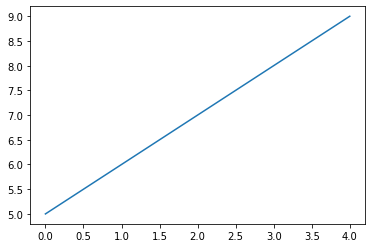

In [103]:
plt.plot(range(5), range(5, 10))

ax = plt.gca()
ax